In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torchvision import models
import torchvision.transforms.functional as TF
import torch
from torch import nn
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from torch.utils.data import Dataset
from torchsummary import summary
from tqdm import tqdm
import PIL
from PIL import Image
from skimage import io, transform
import random
import argparse

from models.cnn_simclr import CNN_SimCLR 
from models.simclr import SimCLR
from utils import augmentation
from utils import ContrastiveLearning
from utils import load_data

/opt/conda/envs/mlenv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load training data
# East Troublesome and McFarland Fires, selected Planetscope images with 4 bands
# These images are tiled and normalized into numpy arr based on the fixed max and min values for each band

fdir = "/home/data/PS_Training/"
flist = glob.glob(fdir+"*.npy")

print("There are %d tiles from the two fires." %len(flist))

band_dict = {1: "Band 1 - Blue", 2: "Band 2 - Green", 3: "Band 3 - Red", 4: "Band 4 - NIR"}

There are 4382607 tiles from the two fires.


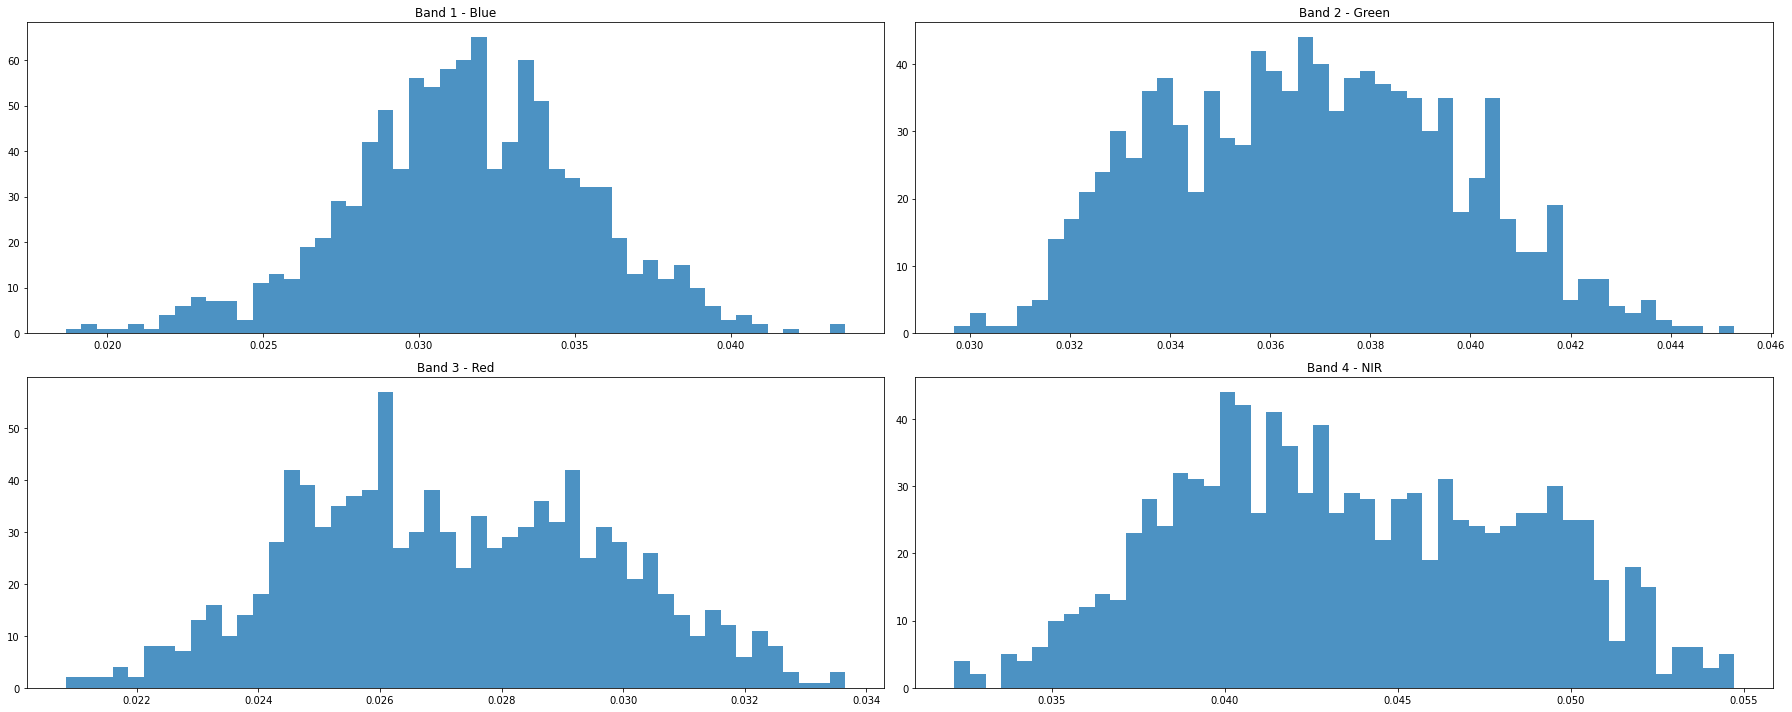

In [3]:
# Distribution of the normalized bands (random sample)

test = np.load("/home/data/PS_Training/McFarland_PlanetScope20210825_0200_0423.npy")

fig, ax = plt.subplots(2,2, figsize=(25,10), tight_layout=True)
for j in range(0,4):
    img_b = test[j,:,:]
    ax[j//2,j%2].hist(img_b.flatten(), alpha=0.8,bins=50)
    ax[j//2,j%2].set_title(band_dict[j+1])
plt.show()

In [4]:
# data augmentation setting
# transform fuction
# Check the parameters in the transform functions if you need to change any of them

list_trans =[transforms.RandomHorizontalFlip(p=0.5),
            augmentation.FixedRotationTransform(angles=[90,180,270]),
            transforms.GaussianBlur(kernel_size=(1, 3), sigma=(0.0001, 0.001)),
            transforms.RandomResizedCrop(32,scale=(0.4,0.9),interpolation = TF.InterpolationMode.BICUBIC)]

In [5]:
# setup hyperparameters
batch_size = 1024
workers = 20
arch = "Simple_CNN"
num_trans = 4
out_dim = 128
n_views = 2
temperature = 0.07
log_every_n_steps = 100
checkpoint_every_n_steps = 1000
learning_rate = 0.0003
weight_decay = 1e-4
epochs = 100

args_dict = {"device":torch.device("cuda" if torch.cuda.is_available() else "cpu"), "arch": arch,
        "gpu_index":0,"n_views": n_views,"temperature": temperature,"log_every_n_steps": log_every_n_steps, 
        "checkpoint_every_n_steps": checkpoint_every_n_steps,
        "batch_size": batch_size, "out_dim": out_dim, "fp16_precision":True, "seed": 64, #1st: 21; 2nd: 15; 3nd: 64
        "weight_decay":weight_decay,"lr": learning_rate, "epochs":epochs, "workers":workers}

In [6]:
# data augmentation for the contrastive learning
transformed_all_img_dataset = load_data.Load_Transformed_Dataset(flist, transform = ContrastiveLearning.ContrastiveLearningViewGenerator(ContrastiveLearning.ContrastiveLearningDataset(num_trans,list_trans).get_trans_func(),n_views=2))

In [7]:
# load the transformed data
train_loader = DataLoader(transformed_all_img_dataset, 
                          batch_size, shuffle=True, 
                          num_workers=workers, 
                          pin_memory=True, drop_last=True)

In [8]:
# training on gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.deterministic = True
cudnn.benchmark = True

In [ ]:
model = CNN_SimCLR(n_channels=4,tile_size=32,out_dim=256)
model= nn.DataParallel(model) #Distribute the model on GPUs, parallel computing
model.to(device)

optimizer = torch.optim.Adam(model.parameters(),learning_rate , weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader), eta_min=0, last_epoch=-1)

simclr = SimCLR(model=model, optimizer=optimizer, scheduler=scheduler, args_dict=args_dict)
simclr.train(train_loader)

In [34]:
# print name and shape of each layer
for name, param in model.named_parameters():
    print(name)
    print(param.shape)

module.encoder.conv.0.0.weight
torch.Size([32, 4, 3, 3])
module.encoder.conv.0.0.bias
torch.Size([32])
module.encoder.conv.0.2.weight
torch.Size([32, 32, 3, 3])
module.encoder.conv.0.2.bias
torch.Size([32])
module.encoder.conv.1.0.weight
torch.Size([256, 32, 3, 3])
module.encoder.conv.1.0.bias
torch.Size([256])
module.encoder.conv.1.2.weight
torch.Size([256, 256, 3, 3])
module.encoder.conv.1.2.bias
torch.Size([256])
module.projection.0.weight
torch.Size([256, 256])
module.projection.0.bias
torch.Size([256])
module.projection.2.weight
torch.Size([128, 256])
module.projection.2.bias
torch.Size([128])
